I recently came across [*The Perron-Frobenius and the Ranking of Football Teams*](http://stat.wharton.upenn.edu/~steele/Courses/956/Ranking/RankingFootballSIAM93.pdf), an interesting paper in which the author describes four different methods to rank teams in uneven paired competition. He goes on to show how each of these methods depends in some way on the Perron-Frobenius theorem. The Perron-Frobenius theorem provides key insights into the structure of non-negative matrices, especially in terms of their largest eigenvalue and associated eigenvector. For irreducible non-negative matrices, the theorem guarantees the existence of a dominant eigenvalue that is real, simple, and larger than all others in magnitude, with a corresponding non-negative eigenvector.

An uneven paired competition is one in which the outcome of competition between pairs of teams is known, but the pairings are not evenly matched, meaning the competition is not a round robin in which each team is paired with every other team an equal number of times. A good example is regular season football in-conference play for any of the major NCAA Division I conferences: For the 2023 season, the Big 12 had 14 teams, but each team had only 9 conference games. 

Here we focus on the first ranking method, which the author refers to as the "direct method". The direct method formulates the ranking approach as a linear eigenvalue problem which makes direct use of the Perron-Frobenius theorem. For each team under consideration, the goal is to assign a score to each team based on its interactions with other teams, with the goal that the assigned score reflect both the interactions as well as the strength of opponents. We will then compare our data-driven ranking approach with the final regular season standings and assess how they line up. A similar exercise will be performed focusing on the 2021 MLB regular season.
<br>


### Creating the Adjacency Matrix

It is first necessary to construct the adjacency matrix in order to encode interactions between teams. 
Big 12 2023 regular season football results were obtained [here](https://big12sports.com/standings.aspx?standings=193&path=football). Within the matrix, the value in cell $a_{ij}$ is set to 1 if team $i$ defeated team $j$, and 0 otherwise. For games that resulted in tie, $a_{ij} = \frac{1}{2}$, but there were no such cases in 2023 Big 12 regular season conference play.  

The regular season rankings and adjacency matrix can be downloaded from GitHub (links available in the next cell):


In [1]:
%load_ext watermark

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from numpy.linalg import eig

np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


big12_matrix_url = "https://gist.githubusercontent.com/jtrive84/b9b4ff8620f90045a0377f27ec4eb50f/raw/e6923583530edadbe9da1a1f4821e415d8a7e6f2/2023-big-12-adjacency.csv"
big12_rankings_url = "https://gist.githubusercontent.com/jtrive84/0207b8fd18a05e096a89498290b08d4a/raw/462d2b1bef52d96ae20e077f55501bfa23951ae4/2023-big-12-rankings.csv"

# ------------------------------------------------------------------------------

%watermark --python --conda --hostname --machine --iversions



Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.28.0

conda environment: py311

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit

Hostname: JTRIZPC11

numpy     : 2.1.0
matplotlib: 3.9.2
pandas    : 2.2.2
networkx  : 3.3



<br>

Big 12 regular season rankings for 2023:

In [2]:

ranks_big12 = pd.read_csv(big12_rankings_url)

ranks_big12.head(15)


,team,conf_wins,conf_losses,overall_wins,overall_losses,conf_win_pct,overall_win_pct
0,Texas,8,1,12,2,0.889,0.857
1,Oklahoma State,7,2,10,4,0.778,0.714
2,Oklahoma,7,2,10,3,0.778,0.769
3,Iowa State,6,3,7,6,0.667,0.538
4,Kansas State,6,3,9,4,0.667,0.692
5,West Virginia,6,3,9,4,0.667,0.692
6,Texas Tech,5,4,7,6,0.556,0.538
7,Kansas,5,4,9,4,0.556,0.692
8,UCF,3,6,6,7,0.333,0.462
9,TCU,3,6,5,7,0.333,0.417



<br>

The adjacency matrix considers only conference play  (non-conference games excluded):

In [3]:

adj_big12 = pd.read_csv(big12_matrix_url)

adj_big12.head(15)


,Unnamed: 0,Baylor,BYU,Cincinnati,Houston,Iowa State,Kansas,Kansas State,Oklahoma,Oklahoma State,TCU,Texas,Texas Tech,UCF,West Virginia
0,Baylor,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,BYU,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,Cincinnati,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Houston,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Iowa State,1,1,1,0,0,0,1,0,1,1,0,0,0,0
5,Kansas,0,1,1,0,1,0,0,1,0,0,0,0,1,0
6,Kansas State,1,0,0,1,0,1,0,0,0,1,0,1,1,0
7,Oklahoma,0,1,1,0,1,0,0,0,0,1,1,0,1,1
8,Oklahoma State,0,1,1,1,0,1,1,1,0,0,0,0,0,1
9,TCU,1,1,0,1,0,0,0,0,0,0,0,0,0,0


<br>

For each row in `adj_big12`, 1 indicates that team at row $i$ defeated the team in column $j$. For example, Oklahoma defeated BYU 31-24 in 2023, so the value at the intersection of row Oklahoma and column BYU is 1. The value at the intersection of row BYU and column Oklahoma is 0, since BYU did not defeat Oklahoma in 2023, and they only faced each other in one contest. 

The sum of each row in the adjacency matrix represents the number of regular season wins in conference play for a given team. Texas was 8-1 in 2023 regular season conference play, therefore the sum of the Texas row is 8. The columnar sum represents the number of losses for a given team (for Texas, this is 1). 

We can use NetworkX to visualize the relationships encoded in the adjacency matrix (each node label corresponds to the alphabetical enumeration of teams: 0=Baylor, 1=BYU, ... 13=West Virginia). Edges indicate whether team $i$ and team $j$ faced each other in a regular season contest:


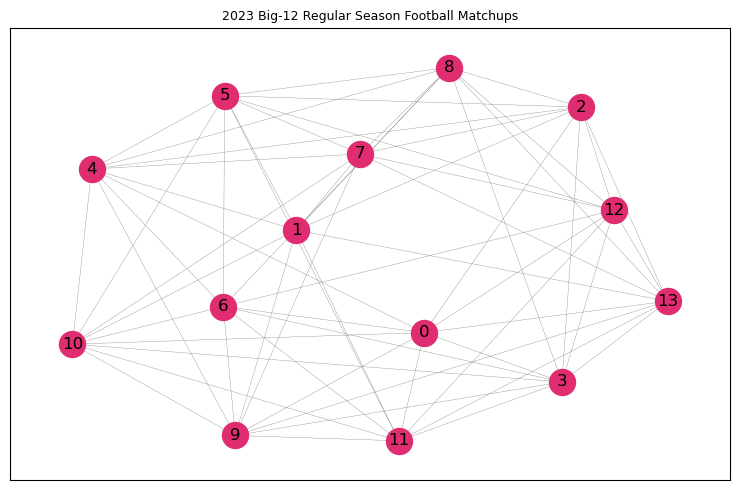

In [4]:

import networkx as nx
import matplotlib.pyplot as plt

# Create adjacency matrix as Numpy array. 
# team_names = dfadj["Unnamed: 0"].values
A = adj_big12.drop("Unnamed: 0", axis=1).values
G = nx.from_numpy_array(A)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), tight_layout=True)
ax.set_title(
    "2023 Big-12 Regular Season Football Matchups", 
    color="#000000", loc="center", weight="normal", fontsize=9
)
nx.draw_networkx(
    G, node_color="#E02C70", node_size=350, ax=ax, with_labels=True, 
    edge_color="grey", width=.25, pos=nx.spring_layout(G, seed=516)
)



<br>

The adjacency matrix, $A$:

In [5]:

A


array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]])


<br>

If we create an initial ranking vector $r_{0}$ with all values set to 1, the the $i^{th}$ component of $Ar_{0}$ is the winning percentage for team $i$ (after dividing by the number of games played):


In [6]:

r0 = np.ones(14)
win_pcts = A @ r0 / 9

pairs = zip(adj_big12.columns[1:], win_pcts.tolist())

for tt in pairs:
    print(tt)


('Baylor', 0.2222222222222222)
('BYU', 0.2222222222222222)
('Cincinnati', 0.1111111111111111)
('Houston', 0.2222222222222222)
('Iowa State', 0.6666666666666666)
('Kansas', 0.5555555555555556)
('Kansas State', 0.6666666666666666)
('Oklahoma', 0.7777777777777778)
('Oklahoma State', 0.7777777777777778)
('TCU', 0.3333333333333333)
('Texas', 0.8888888888888888)
('Texas Tech', 0.5555555555555556)
('UCF', 0.3333333333333333)
('West Virginia', 0.6666666666666666)


<br>

This aligns with values in the *conf_win_pct* column from `ranks_big12`.

The $i^{th}$ component of $A^{2}r_{0}$ represents the average winning percentage of the teams that team $i$ defeated. As the author highlights, $A^{2}r_{0}$ can be considered a proxy for strength of schedule. In the limit as $n$ goes to infinity, $A^{n}r_{0}/|A^{n}r_{0}|$ converges to the unique positive eigenvector of $A$, and the magnitude of the entries of this eigenvector gives a ranking of teams.

If $A$ has nonnegative entries (which will always be the case given out definition of $A$), then it has an eigenvector $\vec{r}$ with non-negative entries associated with a positive eigenvalue $\lambda$. If $A$ is irreducible, then $\vec{r}$ has strictly positive entries and the corresponding eigenvalue is the one of largest absolute value. Note however that if $\vec{r}$ is an eigenvector of $A$, so is $-\vec{r}$. In practice, we simply take the absolute value of the eigenvector associated with the largest eigenvalue. Note that for $A$ to be irreducible, there can be no winless teams.


The steps for deriving our rankings are outlined below:

1. Construct the adjacency matrix $A$, in which entry $a_{ij}$ represents the number of times team $i$ defeated team $j$. 

2. Perform the eigendecomposition of $A$, factoring the matrix into its eigenvalues and eigenvectors. 

3. Identify the index of the largest eigenvalue. 

4. Extract the eigenvector at the index identified in step 3. If using Numpy and the maximum eigenvalue is found at index $j$, the corresponding eigenvector $\vec{r}$ will be located in column $j$. 

5. Take the absolute value of $\vec{r}$. The value at index $i$ in $\vec{r}$ represents the score for the team at the same index (for the Big 12 example, index 0 = Baylor, index 1 = BYU, ...). 

6. Sort the eigenvector scores in decreasing order; higher performing teams will have a larger value, poorer performing teams will have a smaller value. 

<br>

Keep in mind that using a binary encoding scheme in a football setting, where each team may only compete once per season, overlooks information that could enhance the encoding. As it stands, a victory by 80 points for team A over team B is treated the same as a victory in triple overtime. In sports where teams face each other multiple times in a season, $a_{ij}$ serves as a better indicator of the relative strength between the two teams. We'll explore regular season Major League Baseball results later.

The next cell demonstrates how to implement the ranking procedure using Numpy.


In [7]:

from numpy.linalg import eig

# Adjacency matrix as Numpy array.
A = adj_big12.drop("Unnamed: 0", axis=1).values.astype(float)

# Perform eigendecomposition of A. 
e_vals, e_vecs = eig(A)

# Identify index of largest eigenvalue. 
e_val1_indx = np.argmax(e_vals)

# Extract real part of eigenvector at index e_val1_indx. 
e_vec1 = np.abs(e_vecs[:, e_val1_indx])

# Get indices associated with each team.
indices = np.argsort(e_vec1)[::-1]

# Associate ranks with teams. 
teams = adj_big12.columns[1:]
ranked_teams = teams[indices]

for team in ranked_teams:
    print(team)


Texas
Oklahoma State
Oklahoma
Kansas
Iowa State
Kansas State
Texas Tech
West Virginia
UCF
Houston
BYU
TCU
Baylor
Cincinnati



<br> 

We can compare actual vs. predicted rankings to see how well the direct method performed:

In [8]:

for jj, team in enumerate(ranked_teams):
    actual_rank = ranks_big12[ranks_big12.team==team].index.item()
    print(f"{team}: actual/predicted : {actual_rank}/{jj}")



Texas: actual/predicted : 0/0
Oklahoma State: actual/predicted : 1/1
Oklahoma: actual/predicted : 2/2
Kansas: actual/predicted : 7/3
Iowa State: actual/predicted : 3/4
Kansas State: actual/predicted : 4/5
Texas Tech: actual/predicted : 6/6
West Virginia: actual/predicted : 5/7
UCF: actual/predicted : 8/8
Houston: actual/predicted : 10/9
BYU: actual/predicted : 11/10
TCU: actual/predicted : 9/11
Baylor: actual/predicted : 12/12
Cincinnati: actual/predicted : 13/13



There are a few discrepancies, but the ranks are largely consistent. An interesting discrepancy is Kansas, having an actual rank of 7 vs. a predicted rank of 3. It's difficult to say why Kansas is given such a high rank, but it may have to do with strength of schedule. 

For the bottom five teams, the direct method does a good job. Three of the five teams have the same in-conference winning percentage, therefore slight out-of-orderings aren't of concern. 

Next let's look at a more substantial example: All games for the 2021 MLB regular season.

<br>

### MLB Example


A Major League Baseball dataset with game results from 2016-2021 is available on [Kaggle](https://www.kaggle.com/datasets/josephvm/mlb-game-data). The *games.csv* dataset has information about each contest that can be used to build an adjacency matrix. We load the dataset and inspect the first few records:

In [9]:

import numpy as np
import pandas as pd

np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df = pd.read_csv("C:/Users/jtriv/datasets/MLB/games.csv")

print(f"df.shape: {df.shape}")

df.head(3)


df.shape: (13439, 43)


,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,Walks Issued - Away,Walks Issued - Home,Stolen Bases - Away,Stolen Bases - Home,Strikeouts Thrown - Away,Strikeouts Thrown - Home,Total Bases - Away,Total Bases - Home,Stadium,Date,Location,Odds,O/U,Attendance,Capacity,Duration,Umpires,WIN - Pitcher - Stats,WIN - Pitcher - Id,WIN - Pitcher - Name,WIN - Pitcher - AbbrName,WIN - Pitcher - Record,LOSS - Pitcher - Stats,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
0,360403123,STL,0-1,0-1 Away,PIT,Jan-00,1-0 Home,1.0,4.0,NaN,5.0,5.0,0.0,0.0,5.0,14.0,5.0,13.0,\n\n\n\n\n\t\t\t\t\t\t\tPNC Park\n\t\t\t\t\t\t...,2016-04-03T17:00Z,"Pittsburgh, Pennsylvania\n\t\t\t\t\t\t\t\n\t\t...",NaN,NaN,"39,500","38,362",3:02,"Home Plate Umpire - Jerry Layne, First Base Um...","6.0 IP, 0 ER, 10 K, 5 BB",6211.0,Francisco Liriano,F. Liriano,(1-0),"6.0 IP, 3 ER, 3 K, 3 BB",5403.0,Adam Wainwright,A. Wainwright,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
1,360403130,TOR,Jan-00,1-0 Away,TB,0-1,0-1 Home,5.0,3.0,NaN,1.0,3.0,0.0,0.0,7.0,16.0,11.0,11.0,\n\n\n\n\n\t\t\t\t\t\t\tTropicana Field\n\t\t\...,2016-04-03T20:00Z,"St. Petersburg, Florida\n\t\t\t\t\t\t\t\n\t\t\...",NaN,NaN,"31,042","31,042",2:51,"Home Plate Umpire - Mike Everitt, First Base U...","8.0 IP, 3 ER, 5 K, 1 BB",32815.0,Marcus Stroman,M. Stroman,(1-0),"5.0 IP, 2 ER, 12 K, 3 BB",31003.0,Chris Archer,C. Archer,(0-1),"1.0 IP, 0 ER, 2 K, 0 BB",32693.0,Roberto Osuna,R. Osuna,-1.0,NaN
2,360403107,NYM,0-1,0-1 Away,KC,Jan-00,1-0 Home,3.0,4.0,NaN,2.0,6.0,0.0,1.0,3.0,9.0,8.0,9.0,\n\n\n\n\n\t\t\t\t\t\t\tKauffman Stadium\n\t\t...,2016-04-04T00:30Z,"Kansas City, Missouri\n\t\t\t\t\t\t\t\n\t\t\t\...",NaN,NaN,"40,030","37,903",3:13,"Home Plate Umpire - Gerry Davis, First Base Um...","6.0 IP, 0 ER, 5 K, 3 BB",6401.0,Edinson Volquez,E. Volquez,(1-0),"5.2 IP, 3 ER, 2 K, 2 BB",31214.0,Matt Harvey,M. Harvey,(0-1),"1.0 IP, 0 ER, 2 K, 1 BB",28957.0,Wade Davis,W. Davis,-1.0,NaN



<br>

It is first necessary to filter down to 2021 regular season games. If "postseason info" column is null, we assume the game is a regular season matchup. The "Date" column is used to extract the year.

In order to create the adjacency matrix only "away", "home", "away-score" and "home-score" need be retained. All other columns are removed:

In [10]:

df["yyyy"] = pd.to_datetime(df["Date"]).dt.year

df21 = (
    df[(pd.isnull(df["postseason info"])) & (df["yyyy"]==2021)]
    .dropna(subset=["away", "home", "away-score", "home-score"])
    .rename({"away-score": "away_score", "home-score": "home_score"}, axis=1)
    [["away", "home", "away_score", "home_score"]]
    .reset_index(drop=True)
)

print(f"df21.shape: {df21.shape}")

df21.head(15)


df21.shape: (2310, 4)


,away,home,away_score,home_score
0,TOR,NYY,3.0,2.0
1,CLE,DET,2.0,3.0
2,MIN,MIL,5.0,6.0
3,PIT,CHC,5.0,3.0
4,ATL,PHI,2.0,3.0
5,ARI,SD,7.0,8.0
6,LAD,COL,5.0,8.0
7,STL,CIN,11.0,6.0
8,TB,MIA,1.0,0.0
9,TEX,KC,10.0,14.0



<br> 

All 30 MLB teams are represented in the "home" and away" columns. An empty DataFrame is created with columns and rows indexed using the 30 teams ordered alphabetically. 

In [11]:

# Create empty DataFrame with rows and columns indexed by the 30 MLB teams.
mlb_teams = sorted(df21["home"].unique().tolist())
dfadj = pd.DataFrame(index=mlb_teams, columns=mlb_teams)
dfadj.loc[:,:] = 0

dfadj


,ARI,ATL,BAL,BOS,CHC,CHW,CIN,CLE,COL,DET,HOU,KC,LAA,LAD,MIA,MIL,MIN,NYM,NYY,OAK,PHI,PIT,SD,SEA,SF,STL,TB,TEX,TOR,WSH
ARI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BAL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BOS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CIN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CLE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
COL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



<br>

We iterate over `df21`, updating values in `dfadj` according to the following rules:

- If team in row $i$ defeated team in column $j$, $a_{ij}$ is incremented by 1. 
- If team in row $i$ lost to team in column $j$, $a_{ji}$ is incremented by 1. 
- If the contest resulted in a tie, $a_{ij}$ and $a_{ji}$ are incremented by $\frac{1}{2}$, but there are no ties in `df21`.

A dictionary `dresults` tracking wins and losses for each team is also created, in order to use regular season winning percentage as a proxy to compare against our direct method rankings.  


In [12]:

dresults = {kk: {"wins": 0, "losses": 0} for kk in dfadj.columns}

for rr in df21.itertuples(index=False):

    ii, jj, ii_score, jj_score = rr.away, rr.home, rr.away_score, rr.home_score

    if ii_score == jj_score:
        dfadj.at[ii, jj]+=.5
        dfadj.at[jj, ii]+=.5

    elif ii_score > jj_score:
        dfadj.at[ii, jj]+=1
        dresults[ii]["wins"]+=1
        dresults[jj]["losses"]+=1

    else:
        dfadj.at[jj, ii]+=1
        dresults[jj]["wins"]+=1
        dresults[ii]["losses"]+=1

dfadj

,ARI,ATL,BAL,BOS,CHC,CHW,CIN,CLE,COL,DET,HOU,KC,LAA,LAD,MIA,MIL,MIN,NYM,NYY,OAK,PHI,PIT,SD,SEA,SF,STL,TB,TEX,TOR,WSH
ARI,0,1,0,0,2,0,6,0,9,0,1,0,0,3,2,1,0,1,0,0,4,4,8,2,2,1,0,1,0,3
ATL,4,0,3,1,5,0,4,0,2,0,0,0,0,2,11,3,0,9,1,0,10,4,4,0,3,5,1,0,0,12
BAL,0,0,0,6,0,0,0,2,0,2,3,4,2,0,2,0,2,1,8,3,1,0,0,2,0,0,1,4,5,3
BOS,0,3,13,0,0,3,0,4,0,3,2,5,3,0,2,0,3,4,10,3,3,0,0,4,0,0,8,2,8,3
CHC,4,2,0,0,0,1,8,1,2,2,0,0,0,2,1,4,2,4,0,0,2,14,5,0,1,9,0,0,0,4
CHW,0,0,5,2,5,0,3,9,0,9,2,8,2,0,0,1,12,0,0,4,0,3,0,3,0,2,3,5,4,0
CIN,1,3,0,0,11,1,0,3,5,1,0,2,0,3,5,9,2,3,0,0,3,12,1,0,1,9,0,0,0,5
CLE,0,0,5,2,3,7,2,0,0,12,1,13,5,0,0,0,7,0,3,2,0,1,0,3,0,2,1,4,1,0
COL,10,4,0,0,2,0,2,0,0,0,2,0,1,6,4,2,0,1,0,1,5,4,10,2,3,3,0,4,0,4
DET,0,0,5,3,1,7,2,5,0,0,4,8,1,0,0,3,6,0,3,1,0,1,0,5,0,3,4,6,3,0



<br>

Convert `dresults` into a DataFrame and add win_pct column:


In [13]:

dfresults = (
    pd.DataFrame().from_dict(dresults, orient="index")
    .reset_index(drop=False, names="team")
)

# Compute winning percentage. 
dfresults["win_pct"] = dfresults["wins"] / (dfresults["wins"] + dfresults["losses"])

# Sort values by win_pct. 
dfresults = (
    dfresults.sort_values("win_pct", ascending=False)
    .reset_index(drop=True)
)

# Add win_pct rank column.
dfresults["rank0"] = dfresults.index + 1

dfresults.head(30)


,team,wins,losses,win_pct,rank0
0,SF,105,53,0.664557,1
1,LAD,106,54,0.662500,2
2,TB,98,62,0.612500,3
3,HOU,94,66,0.587500,4
4,MIL,89,65,0.577922,5
5,BOS,86,64,0.573333,6
6,NYY,86,67,0.562092,7
7,ATL,84,66,0.560000,8
8,TOR,82,65,0.557823,9
9,CHW,82,66,0.554054,10



<br>

rank0 will be used to compare our results against. Let's visualize the regular season matchup network:

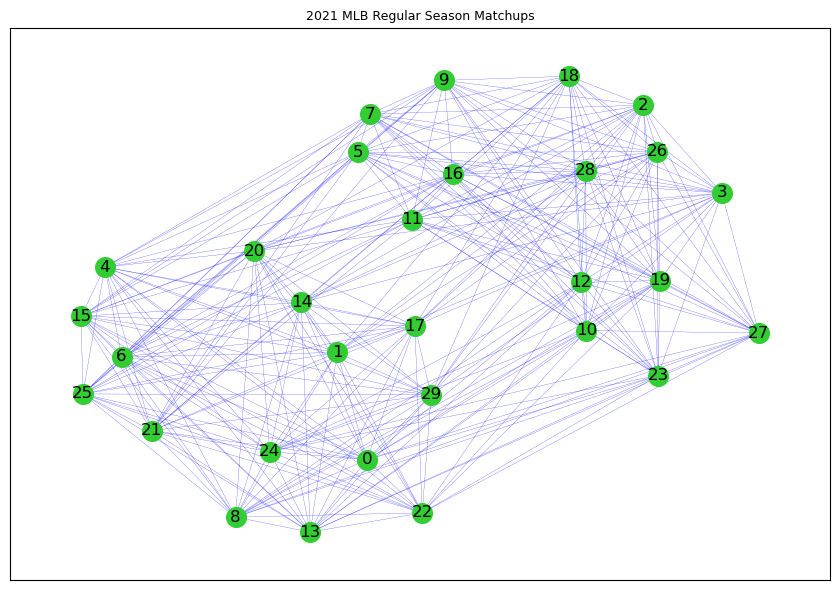

In [14]:

import networkx as nx
import matplotlib.pyplot as plt

# Create adjacency matrix as Numpy array. 
A = dfadj.values.astype(float)
G = nx.from_numpy_array(A)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 6), tight_layout=True)

ax.set_title(
    "2021 MLB Regular Season Matchups", 
    color="#000000", loc="center", weight="normal", fontsize=9
)
nx.draw_networkx(
    G, node_color="#32cd32", node_size=200, ax=ax, with_labels=True, 
    edge_color="blue", width=.15, pos=nx.spring_layout(G, seed=516)
)


<br>

Next we perform the same steps carried out for the Big 12 analysis:

In [15]:

from numpy.linalg import eig


# Adjacency matrix as Numpy array.
A = dfadj.values.astype(float)

# Perform eigendecomposition of A. 
e_vals, e_vecs = eig(A)

# Identify index of largest eigenvalue. 
e_val1_indx = np.argmax(e_vals)

# Extract real part of eigenvector at index e_val1_indx. 
e_vec1 = np.abs(e_vecs[:, e_val1_indx])

# Get indices associated with each team.
indices = np.argsort(e_vec1)[::-1]

# Associate ranks with teams. 
teams = dfadj.columns
ranked_teams = teams[indices]

for team in ranked_teams:
    print(team)


HOU
TB
LAD
SF
SEA
NYY
OAK
BOS
TOR
CHW
MIL
LAA
STL
SD
DET
CLE
ATL
KC
CIN
MIN
PHI
COL
TEX
CHC
MIA
WSH
BAL
NYM
PIT
ARI



<br>

Again comparing actual vs. predicted ranks, using regular season winning percentage as a proxy for actual rank:

In [16]:

for jj, team in enumerate(ranked_teams, start=1):
    actual_rank = dfresults[dfresults.team==team]["rank0"].item()
    print(f"{team}: actual/predicted : {actual_rank}/{jj}")


HOU: actual/predicted : 4/1
TB: actual/predicted : 3/2
LAD: actual/predicted : 2/3
SF: actual/predicted : 1/4
SEA: actual/predicted : 11/5
NYY: actual/predicted : 7/6
OAK: actual/predicted : 13/7
BOS: actual/predicted : 6/8
TOR: actual/predicted : 9/9
CHW: actual/predicted : 10/10
MIL: actual/predicted : 5/11
LAA: actual/predicted : 18/12
STL: actual/predicted : 12/13
SD: actual/predicted : 17/14
DET: actual/predicted : 19/15
CLE: actual/predicted : 15/16
ATL: actual/predicted : 8/17
KC: actual/predicted : 22/18
CIN: actual/predicted : 16/19
MIN: actual/predicted : 21/20
PHI: actual/predicted : 14/21
COL: actual/predicted : 20/22
TEX: actual/predicted : 27/23
CHC: actual/predicted : 24/24
MIA: actual/predicted : 25/25
WSH: actual/predicted : 26/26
BAL: actual/predicted : 29/27
NYM: actual/predicted : 23/28
PIT: actual/predicted : 28/29
ARI: actual/predicted : 30/30


: 


<br>

The Houston Astros are considered the best team based on the direct method, which is encouraging as they ultimately reached the 2021 World Series. One of the biggest discrepancies is with the Atlanta Braves, who were 8th in terms of regular season winning percentage but 17th in terms of the direct method. They went on to win the 2021 World Series. Nonetheless, the modeled ranking are reasonable, and it is clear that the direct might be able to provide further insight into how teams rank looking beyond winning percentage. 



